<a href="https://colab.research.google.com/github/vatfancio/Teste/blob/main/growth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Instalando os pacotes que serão utilizados
install.packages('pwt10')
install.packages('broom')
#install.packages('gtsummary')

In [ ]:
#Importando os pacotes que serão utilizados.
library(pwt10)     #Penn World Table 10.1 (PWT)
library(tidyverse) #Manipulação de dados
library(broom)
#library(gtsummary)

In [3]:
#Ao importar o pacote 'pw10' com os dados da PWT, as variáveis já são carregadas no data frame chamado 'pwt10.01'.
#Como vamos usar o pacote 'dplyr', vamos transformar o data frame em 'tibble', formato familiar para esse pacote do R.

df <- as_tibble(pwt10.01)   #Transformando em tibble (formato do dplyr)
#glimpse(df)                #Visualizando tipo de cada variável

A **Penn World Table** é base de dados com informações sobre níveis relativos de rendimento, produção, insumos e produtividade, abrangendo 183 países entre 1950 e 2019.

Para mais informações sobre a PWT:
https://www.rug.nl/ggdc/productivity/pwt/?lang=en

Os detalhes das variáveis da *Penn World Table 10.1* disponíveis nesse pacote do R estão no site:
https://cran.r-project.org/web/packages/pwt10/index.html

Iremos trabalhar com as seguintes variáveis:

* ***ctfp:***  TFP level at current PPPs (USA = 1).
* ***delta:*** Average depreciation rate of the capital stock.
* ***rgdpo:*** Output-side real GDP at chained PPPs (in million 2017 USD).
* ***pop:***   Population (in millions).
* ***emp:*** Number of persons engaged (in millions).
* ***csh_i:*** Share of gross capital formation at current PPPs.
* ***cn:***    Capital stock at current PPPs (in million 2017 USD).



Em um modelo com capital humano, temos a seguinte especificação para a Função de Produção:


$$Y = K^{\alpha} (AH)^{1-\alpha}, \text{ com } H = e^{\psi u}L,$$

em que $u$ representa a fração de tempo que uma pessoa passa aprendendo novas habilidades.

Nesse caso, ela pode ser entendida como anos de escolaridade. Além disso, $\psi$ indica a elasticidade do capital humano em relação a escolaridade, ou seja, o quanto um ano adicional de estudo aumenta o capital humano.


No *Modelo de Solow*, a relação produto-tecnologia no estado estacionário é dada por,

$$\tilde{y}^{*} = \Bigg(\dfrac{s_K}{n + g + \delta}\Bigg)^{\frac{\alpha}{1-\alpha}}$$

Reescrevendo em função do produto por trabalhador,

$$y^{*}(t) = \Bigg(\dfrac{s_K}{n + g + \delta}\Bigg)^{\frac{\alpha}{1-\alpha}}hA(t)$$

In [4]:
ano_inicial <- 1960 #Definindo o *ano inicial* da análise
ano_final   <- 2008 #Definindo o *ano final* da análise

df <-
df |>
  filter(year %in% c(ano_inicial,ano_final)) |>                 #Filtrando anos da base
  select(country,year,rgdpo,delta,emp,pop,csh_i,cn,ctfp,hc) |>  #Selecionando variáveis de interesse
  group_by(country) |>                                          #Agrupando por país
  arrange(year, .by_group = T) |>                               #Rearranjando linha do tempo
  slice(1,n()) |>                                               #Filtrando ano inicial e final para cada país
  mutate(var_year = year - lag(year),                           #Adicionando diferença entre os anos inicial e final
         var_year = max(var_year, na.rm = T),

         n   = (log(emp)  - lag(log(emp)))/var_year,            #Calculando crescimento do número de trabalhadores. (Checar se não deveria ser crescimento populacional?)
         g_a = (log(ctfp) - lag(log(ctfp)))/var_year,           #Calculando crescimento tecnológico

         y_p = rgdpo/emp,                                       #Calculando pib per capita

         g_y = (log(y_p) - lag(log(y_p)))/var_year,             #Calculando o crescimento do pib per capita

         y_p_inicial = lag(y_p)                                 #Pib per capita do período inicial
         ) |>
  ungroup()

In [5]:
#Vamos assumir que o crescimento do número de trabalhadores e crescimento da tecnologia é constante ao longo do tempo.
#Assim, vamos considerar que o crescimento anual entre 1960 e 2019 é o mesmo que entre 1960 e os anos anteriores.
df_inicial <-
df |>
  group_by(country) |>
  mutate(n   = lead(n),
         g_a = lead(g_a)) |>
  filter(year == ano_inicial) |>
  drop_na(y_p,csh_i,g_a,n,delta)

In [6]:
df_an <-      #Definindo a base que será utilizada para análise como 'df_an'
  df |>
  drop_na()   #Excluindo as variáveis com 'missing'

In [ ]:
summary(df_an)
#Pela análise preliminar dos dados, podemos verificar que pelo menos um país apresentou crescimento negativo no período.

#Verificando quais países são esses:
df_an|>
  filter(g_y <= 0)

`geom_smooth()` using formula = 'y ~ x'


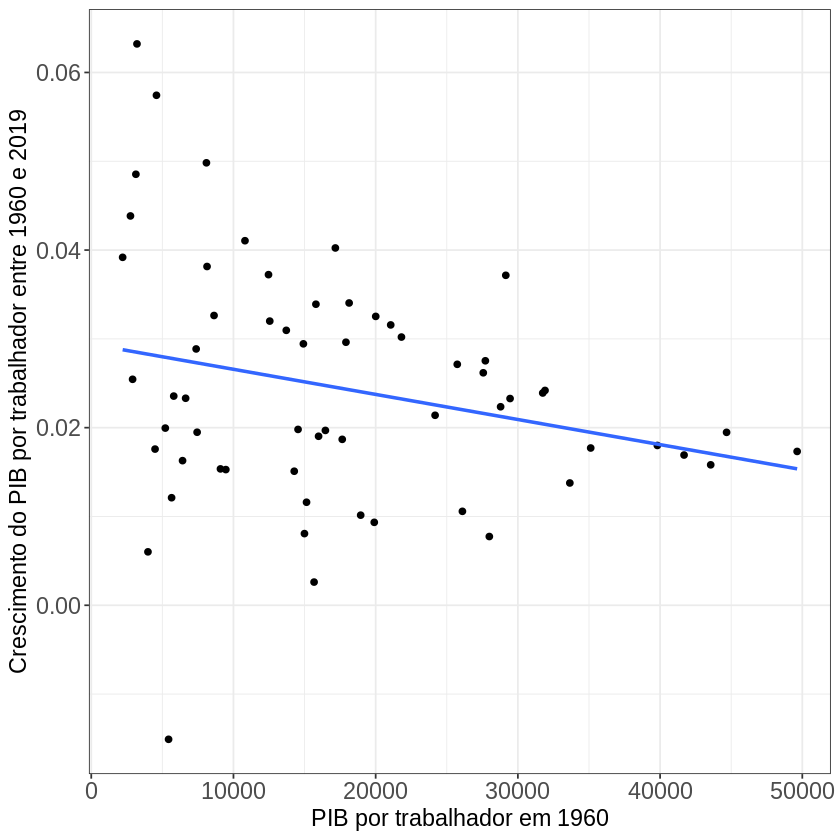

In [8]:
df_an |>
  #filter(g_y >= -0.04) |>                                       #filtrando outliers
  ggplot(aes(x = y_p_inicial, y = g_y)) +                        #definindo variáveis dos eixos x e y
  geom_point() +                                                 #definindo tipo de gráfico como 'pontos'
  geom_smooth(method = 'lm', se = FALSE) +                       #colocando no gráfico a 'linha da regressão'
  ylab("Crescimento do PIB por trabalhador entre 1960 e 2019") + #renomeando texto do eixo y
  xlab("PIB por trabalhador em 1960") +                          #renomeando texto do eixo x
  theme_bw() +                                                   #definindo estilo do gráfico
  theme(axis.title.x = element_text(size = 14),                  #alterando alguns elementos estéticos do gráfico
        axis.text.x  = element_text(size = 14),
        axis.title.y = element_text(size = 14),
        axis.text.y  = element_text(size = 14),
        legend.text  = element_text(size = 14),
        strip.text.x = element_text(size = 14),
        text         = element_text(size = 14))


### **Testes para nível de renda per capita**

1. Modelo base

$$\ln y_{it} = \beta_{0} + \beta_{1} \ln s_{ki} + \beta_{2} \ln(g_A + \delta + n_i) + \epsilon_{i}$$


2. Modelo aumentado com ***capital humano***

$$\ln y_{it} = \beta_{0} + \beta_{1} \ln s_{ki} + \beta_{2} \ln(g_A + \delta + n_i) + \beta_{3} \ln s_{Hi} + \epsilon_{i}$$

em que, $i$ indica o país e $t$ indica o ano.


In [14]:
# 1. Modelo base
lm(data = df_an,
   formula = log(y_p) ~ log(csh_i) + log(g_a + delta + n) ) |>
summary()


Call:
lm(formula = log(y_p) ~ log(csh_i) + log(g_a + delta + n), data = df_an)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.3562 -0.5020  0.1714  0.5314  1.5722 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           11.1070     1.2790   8.684 4.42e-12 ***
log(csh_i)             1.2971     0.3914   3.314  0.00159 ** 
log(g_a + delta + n)  -0.4939     0.4294  -1.150  0.25477    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8035 on 58 degrees of freedom
Multiple R-squared:  0.1699,	Adjusted R-squared:  0.1413 
F-statistic: 5.936 on 2 and 58 DF,  p-value: 0.004513


Vamos replicar a *Figura 3.8* do Livro do Charles Jones e Dietrich Vollarth (Ver referências no final no arquivo).

Nesta figura, temos a relação entre a Taxa de crescimento do PIB por trabalhador entre 1960 e 2008 e o desvio do estado estacionário em 1960. Ela ilustra a afirmação abaixo

**Quanto mais "abaixo" do seu estado estacionário estiver uma economia, tanto mais rápido deve ser seu crescimento. Quanto mais "acima" ela estiver do seu estado estacionário, mais lento será seu crescimento.** (página 60).

Essa previsão do modelo neoclássico de crescimento pode ser escrita como,

$$\dfrac{\dot{\tilde{k}}}{\tilde{k}} = s_{k} \dfrac{\tilde{y}}{\tilde{k}} - (n + g + \delta).$$

em que as variáveis têm os seguintes significados: $\tilde{k}$ a razão capital/tecnologia, $\tilde{y}$ a razão produto/tecnologia, $s_{k}$ a taxa de poupança, $n$ a taxa de crescimento populacional, $g$ a taxa de crescimento tecnológico, $\delta$ a depreciação.


`geom_smooth()` using formula = 'y ~ x'


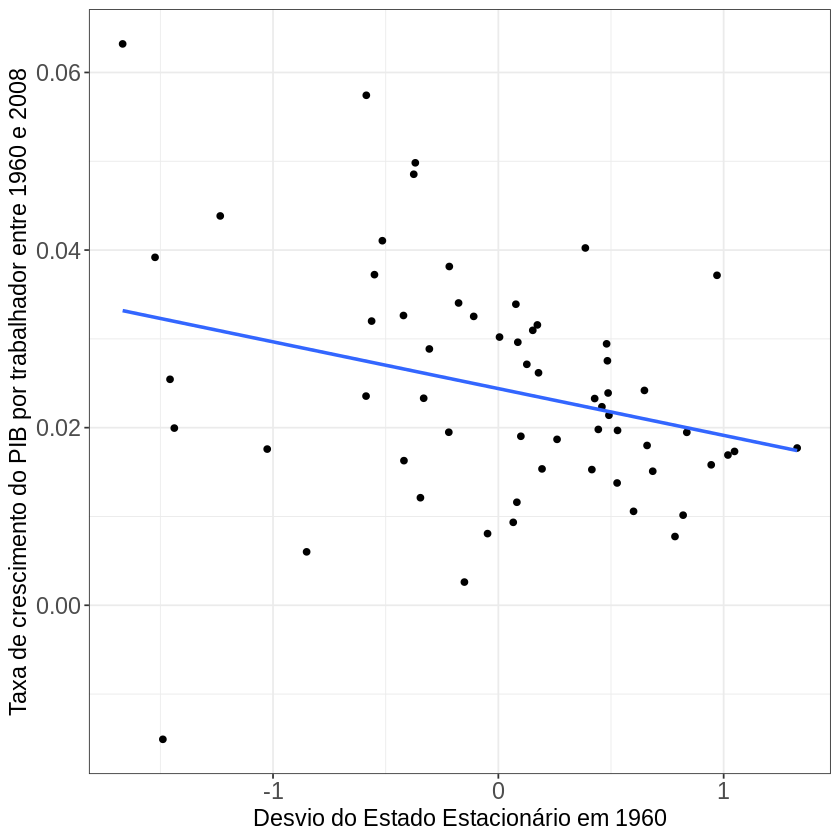

In [11]:
#Para calcular o 'desvio do estado estacionário', vamos considerar o resíduo da regressão do 'Modelo base' para o ano 1960.
fit <-
lm(data = df_inicial,                                                    #Base considerando o ano inicial
   formula = log(y_p) ~ log(csh_i) + log(g_a + delta + n) )              #Regressão modelo base

summary(fit)                                                             #Resultado da regressão

df_inicial_hat <-
df_inicial |>                                                            #Base considerando o ano inicial
  bind_cols(augment(fit)) |>                                             #Combinando a base inicial com os resíduos da regressão
  select(country,.resid)                                                 #Selecionado as colunas com os nomes dos países e resíduos da regressão

df_an |>
  #filter(g_y > -0.04)  |>                                               #Filtrando outliers
  left_join(df_inicial_hat, by='country') |>
  ggplot(aes(x = .resid, y = g_y)) +                                     #Definindo variáveis dos eixos x e y
  geom_point() +                                                         #Definindo tipo de gráfico como 'pontos'
  geom_smooth(method = 'lm', se = FALSE) +                               #Colocando no gráfico a 'linha da regressão'
  ylab("Taxa de crescimento do PIB por trabalhador entre 1960 e 2008") + #Renomeando texto do eixo y
  xlab("Desvio do Estado Estacionário em 1960") +                        #Renomeando texto do eixo x
  theme_bw() +                                                           #Definindo estilo do gráfico
  theme(axis.title.x = element_text(size = 14),                          #Alterando alguns elementos estéticos do gráfico
        axis.text.x  = element_text(size = 14),
        axis.title.y = element_text(size = 14),
        axis.text.y  = element_text(size = 14),
        legend.text  = element_text(size = 14),
        strip.text.x = element_text(size = 14),
        text         = element_text(size = 14))

In [16]:
# 2. Modelo aumentado com capital humano
lm(data = df_an,
   formula = log(y_p) ~ log(y_p_inicial) + log(csh_i) + log(g_a + delta + n) + log(hc) ) |>
  summary()


Call:
lm(formula = log(y_p) ~ log(y_p_inicial) + log(csh_i) + log(g_a + 
    delta + n) + log(hc), data = df_an)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.14378 -0.32230  0.03493  0.34279  1.02303 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)            6.5212     0.9175   7.108 2.30e-09 ***
log(y_p_inicial)       0.5762     0.1111   5.186 3.06e-06 ***
log(csh_i)             0.7455     0.2377   3.136  0.00273 ** 
log(g_a + delta + n)   0.7349     0.2973   2.472  0.01651 *  
log(hc)                1.7353     0.4015   4.322 6.41e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4758 on 56 degrees of freedom
Multiple R-squared:  0.7189,	Adjusted R-squared:  0.6988 
F-statistic: 35.81 on 4 and 56 DF,  p-value: 7.805e-15


### **Testes de convergência (para taxa de crescimento da renda per capita):**

1. Convergência ***incondicional***

$$g_{yi}(0,t) = \beta_{0} + \beta_{1} y_{i0} + \epsilon_{i}$$


2. Convergência ***condicional*** controlando para capital físico e tx. de crescimento populacional

$$g_{yi}(0,t) = \beta_{0} + \beta_{1} y_{i0} + \beta_{2} \ln s_{ki} + \beta_{3} \ln(g_A + \delta + n_i) + \epsilon_{i}$$


3. Convergência ***condicional*** controlando p/ capital físico, ***capital humano*** e tx. de crescimento populacional

$$g_{yi}(0,t) = \beta_{0} + \beta_{1} y_{i0} + \beta_{2} \ln s_{ki} + \beta_{3} \ln(g_A + \delta + n_i) + \beta_{4} \ln s_{Hi} + \epsilon_{i}$$

em que, $i$ indica o país, $t$ indica o ano e *0* o ano inicial.

In [17]:
# 1. Convergência incondicional
lm(data = df_an,
   formula = g_y ~ log(y_p_inicial) ) |>
  summary()


Call:
lm(formula = g_y ~ log(y_p_inicial), data = df_an)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.043989 -0.009032 -0.000128  0.007241  0.031729 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.071375   0.020008   3.567 0.000723 ***
log(y_p_inicial) -0.004939   0.002096  -2.356 0.021813 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01296 on 59 degrees of freedom
Multiple R-squared:  0.08599,	Adjusted R-squared:  0.0705 
F-statistic: 5.551 on 1 and 59 DF,  p-value: 0.02181


In [18]:
# 2. Convergência condicional controlando para capital físico e tx. de crescimento populacional
lm(data = df_an,
   formula = g_y ~ log(y_p_inicial) + log(csh_i) + log(g_a + delta + n) ) |>
  summary()


Call:
lm(formula = g_y ~ log(y_p_inicial) + log(csh_i) + log(g_a + 
    delta + n), data = df_an)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0210681 -0.0095288 -0.0005449  0.0079565  0.0229655 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           0.129598   0.021816   5.940  1.8e-07 ***
log(y_p_inicial)     -0.002970   0.002147  -1.383  0.17202    
log(csh_i)            0.017404   0.005647   3.082  0.00317 ** 
log(g_a + delta + n)  0.019104   0.007018   2.722  0.00858 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01135 on 57 degrees of freedom
Multiple R-squared:  0.3236,	Adjusted R-squared:  0.288 
F-statistic:  9.09 on 3 and 57 DF,  p-value: 5.2e-05


In [19]:
# 3. Convergência condicional controlando p/ capital físico, capital humano e tx. de crescimento populacional
lm(data = df_an,
   formula = g_y ~ log(y_p_inicial) + log(csh_i) + log(g_a + delta + n) + log(hc) ) |>
  summary()



Call:
lm(formula = g_y ~ log(y_p_inicial) + log(csh_i) + log(g_a + 
    delta + n) + log(hc), data = df_an)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0238287 -0.0067145  0.0007278  0.0071415  0.0213131 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           0.135859   0.019115   7.108 2.30e-09 ***
log(y_p_inicial)     -0.008830   0.002315  -3.815 0.000342 ***
log(csh_i)            0.015532   0.004952   3.136 0.002727 ** 
log(g_a + delta + n)  0.015309   0.006193   2.472 0.016506 *  
log(hc)               0.036153   0.008365   4.322 6.41e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.009913 on 56 degrees of freedom
Multiple R-squared:  0.4928,	Adjusted R-squared:  0.4565 
F-statistic:  13.6 on 4 and 56 DF,  p-value: 8.237e-08


### Referências

1. Charles Jones e Dietrich Vollarth. Introdução à Teoria do Crescimento Econômico. 3. ed - Rio de Janeiro. Elsevier, 2015.

2. Pablo Kurlat. A Course in Modern Macroeconomics.

    *Link:* https://sites.google.com/view/pkurlat/a-course-in-modern-macroeconomics?authuser=0

3. Julieta Caunedo. Development accounting: Methods and findings.

    *Link*: https://www.youtube.com/watch?v=lG-DvqsxVfg&list=PLt9jC4Ylzr6BuFVwZNW0hCJureBVMBJ-Z&index=2